In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [3]:
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)
x_train = (x_train - 127.5) / 127.5

batch_size = 256
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
def discriminator_model():

  model = tf.keras.Sequential([
                               tf.keras.layers.Conv2D(64, kernel_size = 5, strides = 2, padding = 'same', input_shape = (28, 28, 1)),
                               tf.keras.layers.LeakyReLU(0.3),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'),
                               tf.keras.layers.LeakyReLU(0.3),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1)
  ])

  return model

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [7]:
def generator_model():

  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(7 * 7 * 256, use_bias = False, input_shape = (z_dim, )),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(0.3),
                               tf.keras.layers.Reshape((7, 7, 256)),
                               tf.keras.layers.Conv2DTranspose(128, kernel_size = 5, strides = 1, padding = 'same', use_bias = False),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(0.3),
                               tf.keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(0.3),
                               tf.keras.layers.Conv2DTranspose(1, kernel_size = 5, strides = 2, padding = 'same', use_bias = False)
  ])

  return model

z_dim = 100
generator = generator_model()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)        

In [11]:
# Define Generator loss
#def generator_loss(fake):
#    return cross_entropy(tf.ones_like(fake), fake)
# Define discriminator loss
#def discriminator_loss(real, fake):
#    d_loss_real = cross_entropy(tf.ones_like(real), real)
#    d_loss_fake = cross_entropy(tf.zeros_like(fake), fake)
#    d_loss = d_loss_real + d_loss_fake
#  return d loss

loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
epochs = 50
n_imgs = 16
seed = tf.random.normal([n_imgs, z_dim])

def train_gan(x_train):

  generator_losses = []
  discriminator_losses = []

  for epoch in range(epochs):

    print('Now running Epoch {}'.format(epoch + 1))

    gen_loss = 0
    disc_loss = 0

    for img in x_train : 

      noise = tf.random.normal((batch_size, z_dim))

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_img = generator(noise, training = True)

        real = discriminator(img, training = True)
        fake = discriminator(gen_img, training = True)

        g_loss = loss(tf.ones_like(fake), fake)
        
        d_loss_real = loss(tf.ones_like(real), real)
        d_loss_fake = loss(tf.zeros_like(fake), fake)
        d_loss = d_loss_real + d_loss_fake

        gen_loss += float(g_loss)
        disc_loss += float(d_loss)
      
      generator_grad = gen_tape.gradient(g_loss, generator.trainable_variables)
      discriminator_grad = disc_tape.gradient(d_loss, discriminator.trainable_variables)

      gen_optimizer.apply_gradients(zip(generator_grad, generator.trainable_variables))
      disc_optimizer.apply_gradients(zip(discriminator_grad, discriminator.trainable_variables))

    if (epoch + 1) == 10 or (epoch + 1) == 30 or (epoch + 1) == 50 :

      print('Epoch : {}/{}'.format(epoch + 1, epochs))
      print_images(generator, seed)

    generator_losses.append(gen_loss / len(x_train))
    discriminator_losses.append(disc_loss / len(x_train))

  return (generator_losses, discriminator_losses)

In [24]:
def print_images(model, seed):

  pred = model(seed, training = False)
  
  plt.figure(figsize = (4, 4))
  for i in range(pred.shape[0]):

    plt.subplot(4, 4, i + 1)
    plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')

  plt.show()

Now running Epoch 1
Now running Epoch 2
Now running Epoch 3
Now running Epoch 4
Now running Epoch 5
Now running Epoch 6
Now running Epoch 7
Now running Epoch 8
Now running Epoch 9
Now running Epoch 10
Epoch : 10/50


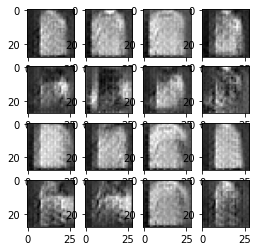

Now running Epoch 11
Now running Epoch 12
Now running Epoch 13
Now running Epoch 14
Now running Epoch 15
Now running Epoch 16
Now running Epoch 17
Now running Epoch 18
Now running Epoch 19
Now running Epoch 20
Now running Epoch 21
Now running Epoch 22
Now running Epoch 23
Now running Epoch 24
Now running Epoch 25
Now running Epoch 26
Now running Epoch 27
Now running Epoch 28
Now running Epoch 29
Now running Epoch 30
Epoch : 30/50


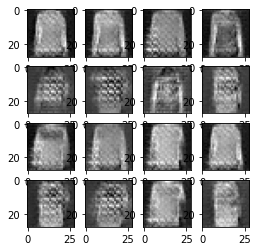

Now running Epoch 31
Now running Epoch 32
Now running Epoch 33
Now running Epoch 34
Now running Epoch 35
Now running Epoch 36
Now running Epoch 37
Now running Epoch 38
Now running Epoch 39
Now running Epoch 40
Now running Epoch 41
Now running Epoch 42
Now running Epoch 43
Now running Epoch 44
Now running Epoch 45
Now running Epoch 46
Now running Epoch 47
Now running Epoch 48
Now running Epoch 49
Now running Epoch 50
Epoch : 50/50


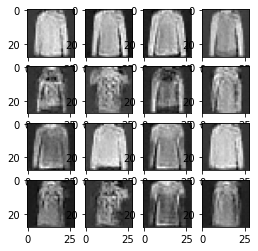

In [25]:
g_loss, d_loss = train_gan(x_train)

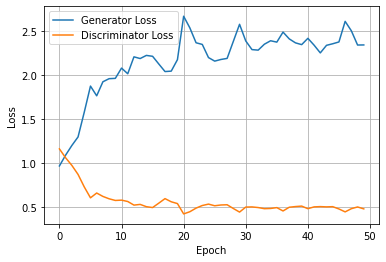

In [26]:
plt.plot(range(epochs), g_loss, '-', label = 'Generator Loss')
plt.plot(range(epochs), d_loss, '-', label = 'Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

Since the generator is working to fool the discriminator, the discriminator eventually learns to identify which image is real and which is fake and thus the discriminator loss decreases. But this also means that the generator is no longer able to fool the discriminator which would mean the the generator loss increases as the discriminator loss decreases. In theory, training the GAN for over 250 epochs would result in the losses being stabilized.